# Day 6 of AoC 2018: Chronal Coordinates
https://adventofcode.com/2018/day/6

## Part one

In [1]:
import pandas as pd
import numpy as np
import altair as alt
from sklearn.neighbors import KNeighborsClassifier
from scipy.spatial import distance

In [2]:
points = pd.read_csv('day06_input.txt', names=['x', 'y'])

In [3]:
len(points)

50

In [4]:
points['label'] = range(len(points))

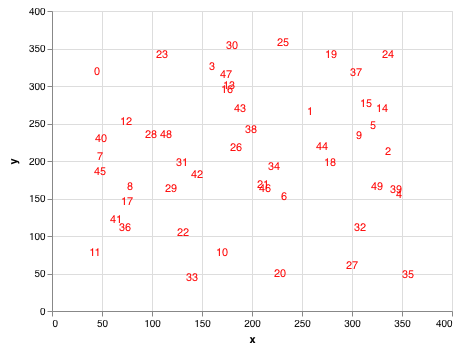

In [5]:
labels = alt.Chart(points).mark_text(color='red').encode(
    x=alt.X('x:Q'),
    y=alt.Y('y:Q'),
    text=alt.Text('label:N')
)
labels

I will make a classifier with k nearest neighbors, using 1 neighbor and Manhattan distance. And then I will use this classifier to predict all points on a grid.

In [6]:
knn = KNeighborsClassifier(n_neighbors=1, metric="manhattan")

In [7]:
knn.fit(points[['x', 'y']].values, np.arange(50))

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='manhattan',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform')

I used [this answer from stackoverflow](https://stackoverflow.com/questions/32208359/is-there-a-multi-dimensional-version-of-arange-linspace-in-numpy) to create the grid

In [8]:
x_min, x_max = points.x.min(), points.x.max()
y_min, y_max = points.y.min(), points.y.max()
grid = np.mgrid[x_min:(x_max+1), y_min:(y_max+1)].reshape(2,-1).T

In [9]:
grid.shape

(98596, 2)

In [10]:
predictions = knn.predict(grid)

In [11]:
predictions_df = pd.DataFrame({'x':grid[:, 0],
                               'y':grid[:, 1],
                               'pred':predictions
                              })

In [12]:
predictions_df.to_csv('day06_grid_predictions.csv', index=False)

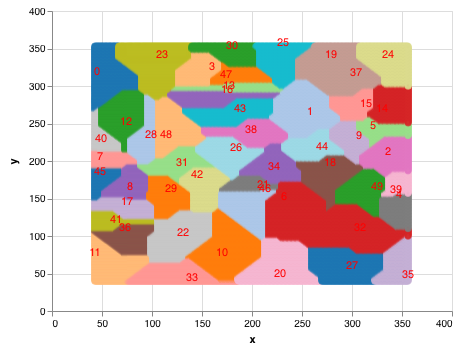

In [13]:
grid_chart = alt.Chart('day06_grid_predictions.csv').mark_point().encode(
    x=alt.X('x:Q'),
    y=alt.Y('y:Q'),
    color=alt.Color('pred:N', legend=None, scale=alt.Scale(scheme='category20')),
    tooltip='pred:N'
)

grid_chart + labels

Looks good! The area that seems to be overlapping are due to the fact that there are only 20 colors in the scheme, while I want to plot 50 zones, we can see that they are indeed separated with the tooltip.

I have to only take into account the finite areas, so any area that "touches" the ends has to be dismissed.

In [14]:
def find_infinite_area(pred, num_labels=50, x_min=x_min, 
                       x_max=x_max, y_min=y_min, y_max=y_max):
    """
    Returns a set of labels the touches the ends
    """
    infinite_area = set()
    x_min
    for label in range(num_labels):
        label_df = pred.query('pred == @label')
        if (x_min in label_df['x'].values) or (x_max in label_df['x'].values)\
          or (y_min in label_df['y'].values) or (y_max in label_df['y'].values):
            infinite_area.add(label)
    return infinite_area

In [15]:
infinite_area = find_infinite_area(predictions_df)
print(infinite_area)

{0, 2, 4, 5, 7, 11, 14, 17, 19, 20, 23, 24, 25, 27, 30, 32, 33, 35, 36, 37, 39, 40, 41, 45}


I update the dataframe

In [16]:
predictions_df['infinite'] = predictions_df['pred'].isin(infinite_area)

In [17]:
predictions_df.to_csv('day06_grid_predictions.csv', index=False)

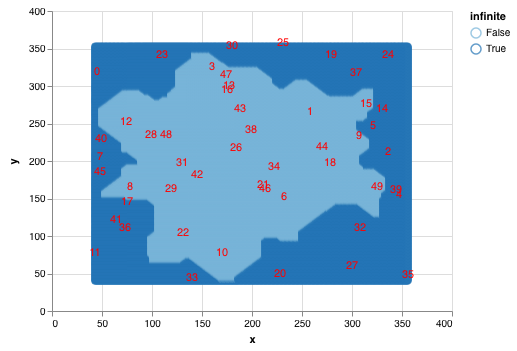

In [18]:
grid_chart.encode(color=alt.Color('infinite:O')) + labels

OK, it seems to have done a good job! Let's now filter those areas and count the number of values, which will give the total area. I will have to take care of points being at an equal distance of 2 data points.

In [19]:
predictions_df.query('not infinite')['pred'].value_counts()[:5]

10    3960
1     3661
6     3454
22    3433
48    2588
Name: pred, dtype: int64

So, the area 10 is the largest. The value does not take into account that I should not count the points that are at the same distance of 2 labels.

In [20]:
area10 = predictions_df.query('pred == 10').loc[:, ['x', 'y']].values

In [21]:
def center_coord(id):
    return points.loc[id, ['x', 'y']].values.reshape(-1, 2)


def matrix_neighbor(ids=None):
    if ids is None:
        # This is from visual inspection
        ids = [33, 20, 22, 42, 46]
    all_neighbors = np.zeros(shape=(len(ids), 2))
    for i, id in enumerate(ids):
        all_neighbors[i, :] = center_coord(id)
    return all_neighbors

In [22]:
coords_neighbors_10 = matrix_neighbor()

In [23]:
distances_neighbors = distance.cdist(area10, coords_neighbors_10, metric='cityblock')

In [24]:
distances_10 = distance.cdist(area10, center_coord(10), metric='cityblock')

In [25]:
differences = distances_neighbors - distances_10

In [26]:
np.sum(np.any(differences == 0, axis=1))

66

There are 66 ties in the distances, so we must substract those from the area.

In [27]:
print(f'Solution for part 1: {len(area10) - 66}')

Solution for part 1: 3894


## Part 2

Let's compute the distance for our grid of points to all the points.

In [28]:
all_distances = distance.cdist(grid, points.loc[:, ['x', 'y']].values, metric='cityblock')

Now, we need to sum all the distances.

In [29]:
sum_distances = np.sum(all_distances, axis=1)

We need to find and count the values that are less than 10000.

In [30]:
print(f'Solution for part 2: {np.sum(sum_distances < 10000)}')

Solution for part 2: 39398


Just for fun, plot this

In [31]:
predictions_df['sum_dist'] = sum_distances
predictions_df['close'] = sum_distances < 10000

In [32]:
predictions_df.to_csv('day06_grid_predictions.csv', index=False)

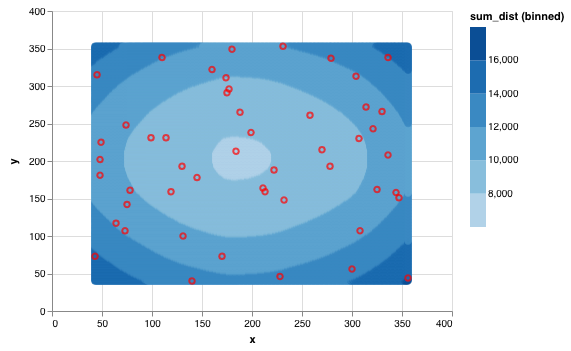

In [33]:
grid_chart.encode(color=alt.Color('sum_dist:Q', bin=True),
                  tooltip=['sum_dist:Q', 'close:O']) + labels.mark_point(color='red')